Import modules

In [1]:
# public
import os
import argparse
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable as V

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image

# custom
from model_layer import Vgg16_all_layer, Vgg19_all_layer, Res152_all_layer, Dense169_all_layer
from generator import GeneratorResnet
from dct import *
from utils import *

ArgumentParser

In [2]:
parser = argparse.ArgumentParser(description='Transferable Perturbation via Frequency Manipulation')
parser.add_argument('--train_dir', default='../dataset/imagenet/train', help='Path for imagenet training data')
parser.add_argument('--batch_size', type=int, default=16, help='Batch size')
parser.add_argument('--epochs', type=int, default=1, help='Number of training epochs')
parser.add_argument('--lr', type=float, default=0.0002, help='Initial learning rate')
parser.add_argument('--eps', type=int, default=10, help='Perturbation budget (0~255)')
parser.add_argument('--model_type', type=str, default='vgg16', help='Victim model: vgg16, vgg19, res152, dense169')
parser.add_argument('--RN', type=lambda x: (str(x).lower() == 'true'), default=False, help='If true, activating the Random Normalization module in training phase')
parser.add_argument('--DA', type=lambda x: (str(x).lower() == 'true'), default=False, help='If true, activating the Domain-agnostic Attention module in training phase')
parser.add_argument('--FA', type=lambda x: (str(x).lower() == 'true'), default=True, help='If true, activating the Frequency Augmentation module in training phase')
parser.add_argument("--rho", type=float, default=0.5, help="Tuning factor")
parser.add_argument("--sigma", type=float, default=16.0, help="Std of random noise")
args = parser.parse_args(args=[])
print(args)

Namespace(DA=False, FA=True, RN=False, batch_size=16, epochs=1, eps=10, lr=0.0002, model_type='vgg16', rho=0.5, sigma=16.0, train_dir='../dataset/imagenet/train')


Control the seed

In [4]:
def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(0)

Define the victim classification model

In [3]:
if args.model_type == 'vgg16':
    model = Vgg16_all_layer.Vgg16()
    layer_idx = 16 # Maxpooling.3
elif args.model_type == 'vgg19':
    model = Vgg19_all_layer.Vgg19()
    layer_idx = 18 # Maxpooling.3
elif args.model_type == 'res152':
    model = Res152_all_layer.Resnet152()
    layer_idx = 5 # Conv3_8
elif args.model_type == 'dense169':
    model = Dense169_all_layer.Dense169()
    layer_idx = 6 # Denseblock.2
else:
    raise Exception('Check the model_type')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

Vgg16(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxP

Define the generative attack model/optimizer/dataset

In [4]:
# Model, Optimizer
netG = GeneratorResnet()
optimG = optim.Adam(netG.parameters(), lr=args.lr, betas=(0.5, 0.999))

# netG = nn.DataParallel(netG, device_ids=[0,1,2,3]) # multi-GPU
netG = netG.to(device)

if args.RN and args.DA:
    save_checkpoint_suffix = 'BIA+RN+DA'
elif args.RN:
    save_checkpoint_suffix = 'BIA+RN'
elif args.DA:
    save_checkpoint_suffix = 'BIA+DA'
elif args.FA:
    save_checkpoint_suffix = 'BIA+FA'
else:
    save_checkpoint_suffix = 'BIA'

# Data, Transform
scale_size = 256
img_size = 224
data_transform = transforms.Compose([
    transforms.Resize(scale_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
])

train_dir = args.train_dir
train_set = datasets.ImageFolder(train_dir, data_transform)
train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, num_workers=4, pin_memory=True)
train_size = len(train_set)
print('Training data size:', train_size)

def default_normalize(t):
    t[:, 0, :, :] = (t[:, 0, :, :] - 0.485) / 0.229
    t[:, 1, :, :] = (t[:, 1, :, :] - 0.456) / 0.224
    t[:, 2, :, :] = (t[:, 2, :, :] - 0.406) / 0.225
    return t

def normalize(t, mean, std):
    t[:, 0, :, :] = (t[:, 0, :, :] - mean) / std
    t[:, 1, :, :] = (t[:, 1, :, :] - mean) / std
    t[:, 2, :, :] = (t[:, 2, :, :] - mean) / std
    return t

Training data size: 1281167


Train

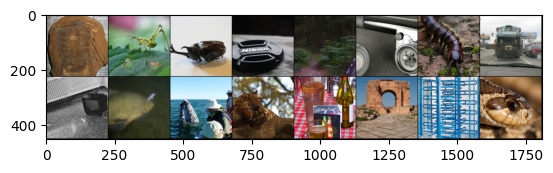

In [5]:
running_loss = 0
epoch = 0
i = 1

img, label = next(iter(train_loader))
img_grid = make_grid(img)
plt.imshow(img_grid.permute(1,2,0))

# print(img.size())
# print(label.size())
# print(grid.size())

# img_sample = transforms.ToPILImage()(img[0])
# plt.imshow(img_sample)
# print("image tensor: ", img[0]) # CxHxW
# print("PIL converted image: ", img_sample) # HxWxC

In [6]:
img = img.to(device)
netG.train()
optimG.zero_grad()

adv1 = netG(img)
adv2 = torch.min(torch.max(adv1, img - args.eps/255.0), img + args.eps/255.0)
adv3 = torch.clamp(adv2, 0.0, 1.0)
adv = adv3

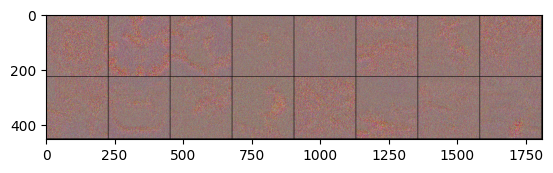

In [32]:
# Visualization
adv_grid1 = make_grid(adv1.cpu())
adv_grid2 = make_grid(adv2.cpu())
adv_grid3 = make_grid(adv3.cpu())
# plt.imshow(adv_grid1.permute(1,2,0))
# plt.imshow(adv_grid2.permute(1,2,0))
# plt.imshow(adv_grid3.permute(1,2,0))

In [7]:
if args.FA:
    gauss = (torch.randn(args.batch_size, 3, img_size, img_size) * (args.sigma / 255)).to(device)
    mask = (torch.rand_like(img) * 2 * args.rho + 1 - args.rho).to(device)
        
    img_dct = dct_2d(img + gauss).to(device)
    img_idct = idct_2d(img_dct * mask)
    img_idct = V(img_idct, requires_grad=True)
    img_FA = torch.clamp(img_idct, 0.0, 1.0)
    img = img_FA
    
    adv_dct = dct_2d(adv + gauss).to(device)
    adv_idct = idct_2d(adv_dct * mask)
    adv_idct = V(adv_idct, requires_grad=True)
    adv_FA = torch.clamp(adv_idct, 0.0, 1.0)
    adv = adv_FA
else:
    pass

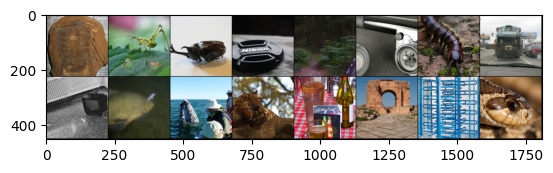

In [10]:
plt.imshow(img_grid.permute(1,2,0))

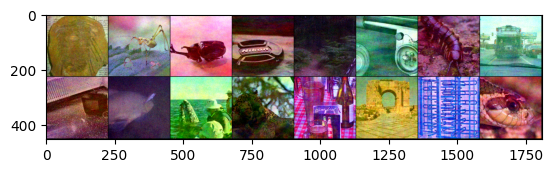

In [12]:
# Visualization
gauss_grid = make_grid(gauss.cpu())
mask_grid = make_grid(mask.cpu())
img_dct_grid = make_grid(img_dct.cpu())
img_idct_grid = make_grid(img_idct.cpu())
img_FA_grid = make_grid(img_FA.cpu())
adv_dct_grid = make_grid(adv_dct.cpu())
adv_idct_grid = make_grid(adv_idct.cpu())
adv_FA_grid = make_grid(adv_FA.cpu())

# plt.imshow(gauss_grid.permute(1,2,0))
# plt.imshow(mask_grid.permute(1,2,0))
# plt.imshow(img_dct_grid.permute(1,2,0))
# plt.imshow(img_idct_grid.permute(1,2,0))
# plt.imshow(img_FA_grid.permute(1,2,0))
# plt.imshow(adv_dct_grid.permute(1,2,0))
# plt.imshow(adv_idct_grid.permute(1,2,0))
plt.imshow(adv_FA_grid.permute(1,2,0))


In [ ]:
if args.RN:
    mean = np.random.normal(0.50, 0.08) # default=(0.50, 0.08) 
    std = np.random.normal(0.75, 0.08) # default=(0.75, 0.08)
    adv_out_slice = model(normalize(adv.clone(), mean, std))[layer_idx]
    img_out_slice = model(normalize(img.clone(), mean, std))[layer_idx]
else:
    adv_out_slice = model(default_normalize(adv.clone()))[layer_idx]
    img_out_slice = model(default_normalize(img.clone()))[layer_idx]

if args.DA:
    attention = abs(torch.mean(img_out_slice, dim=1, keepdim=True)).detach()
else:
    attention = torch.ones(adv_out_slice.shape).cuda()

In [ ]:
loss = torch.cosine_similarity((adv_out_slice*attention).reshape(adv_out_slice.shape[0], -1), 
                                       (img_out_slice*attention).reshape(img_out_slice.shape[0], -1)).mean()
loss.backward()
optimG.step()

In [ ]:
print('Epoch: {0} \t Batch: {1} \t loss: {2:.5f}'.format(epoch, i, running_loss/100))
running_loss = 0
running_loss += abs(loss.item())

save_checkpoint_dir = 'saved_models/{}'.format(args.model_type)
if not os.path.exists(save_checkpoint_dir):
    os.makedirs(save_checkpoint_dir)
save_path = os.path.join(save_checkpoint_dir, 'netG_{}_{}.pth'.format(save_checkpoint_suffix, epoch))

if isinstance(netG, nn.DataParallel):
    torch.save(netG.module.state_dict(), save_path)
else:
    torch.save(netG.state_dict(), save_path)